<a href="https://colab.research.google.com/github/naufalfrdss/DeepLearning/blob/main/UAS/Chapter%2007/Ensemble_learning_and_random_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup & Utility

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import clone
import warnings
warnings.filterwarnings("ignore")

def plot_decision_boundary(clf, X, y, title=None):
    x1s = np.linspace(X[:, 0].min() - .5, X[:, 0].max() + .5, 100)
    x2s = np.linspace(X[:, 1].min() - .5, X[:, 1].max() + .5, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    plt.contourf(x1, x2, y_pred, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    if title:
        plt.title(title)
    plt.grid(True)


Simulasi Coin Toss: Hukum Bilangan Besar

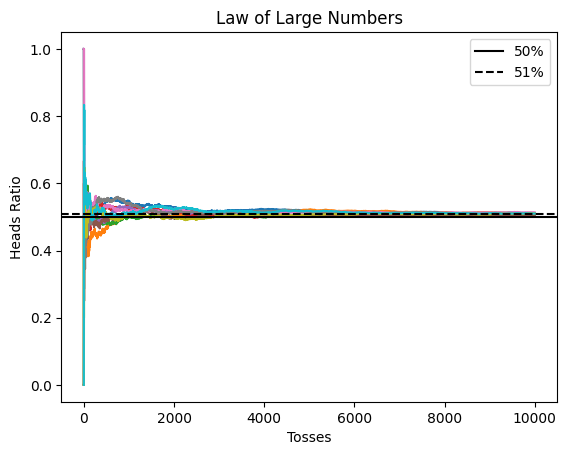

In [7]:
np.random.seed(42)
tosses = (np.random.rand(10000, 10) < 0.51).astype(int)
ratios = np.cumsum(tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)
plt.plot(ratios)
plt.axhline(0.5, c="black", label="50%")
plt.axhline(0.51, c="black", linestyle="--", label="51%")
plt.xlabel("Tosses")
plt.ylabel("Heads Ratio")
plt.legend()
plt.title("Law of Large Numbers")
plt.show()


Soft Voting Classifier

In [8]:
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

log_clf = LogisticRegression()
tree_clf = DecisionTreeClassifier()
svm_clf = SVC(probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt', tree_clf), ('svc', svm_clf)],
    voting='soft'
)

voting_clf.fit(X_train, y_train)
for clf in (log_clf, tree_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    print(f"{clf.__class__.__name__}: {accuracy_score(y_test, clf.predict(X_test)):.2f}")


LogisticRegression: 0.82
DecisionTreeClassifier: 0.91
SVC: 0.93
VotingClassifier: 0.90


Bagging & Random Forest

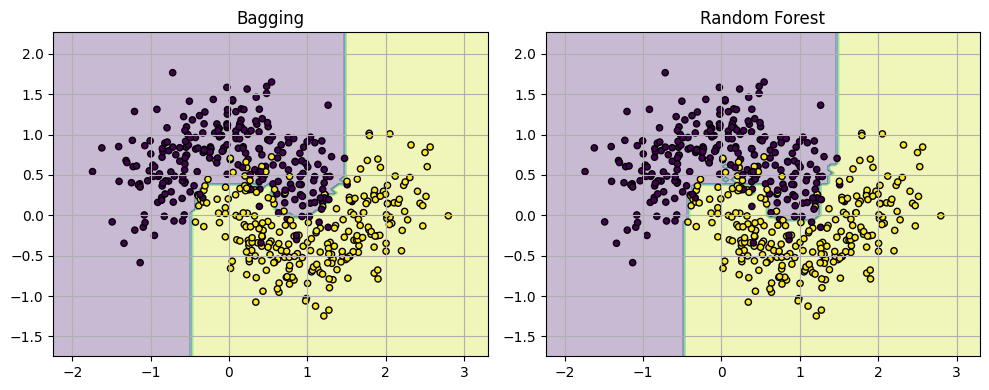

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)
bag_clf.fit(X_train, y_train)

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rf_clf.fit(X_train, y_train)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_decision_boundary(bag_clf, X, y, title="Bagging")
plt.subplot(1,2,2)
plot_decision_boundary(rf_clf, X, y, title="Random Forest")
plt.tight_layout()
plt.show()


Boosting (AdaBoost & Gradient Boosting)

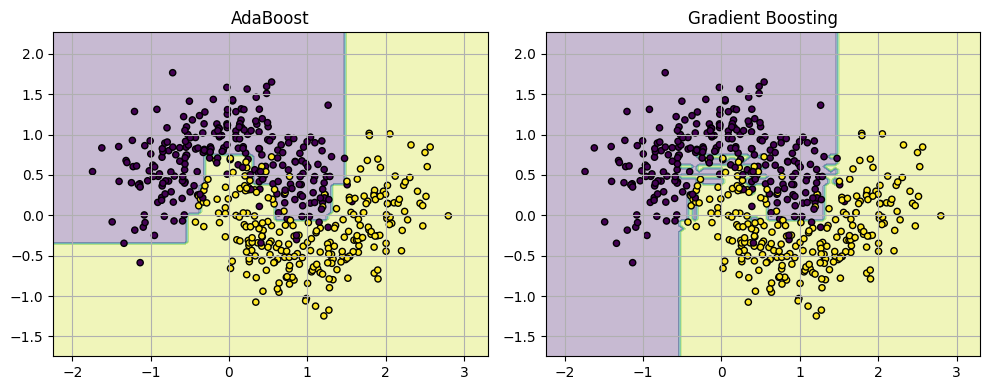

In [12]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

# AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),  # Ganti base_estimator → estimator
    n_estimators=200,
    algorithm="SAMME",  # Hanya ini yang valid di versi terbaru
    learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

# GradientBoostingClassifier
gbrt = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=200,
    learning_rate=0.1
)
gbrt.fit(X_train, y_train)

# Visualisasi (pastikan fungsi plot_decision_boundary didefinisikan)
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plot_decision_boundary(ada_clf, X, y, title="AdaBoost")

plt.subplot(1, 2, 2)
plot_decision_boundary(gbrt, X, y, title="Gradient Boosting")

plt.tight_layout()
plt.show()

Early Stopping pada Gradient Boosting

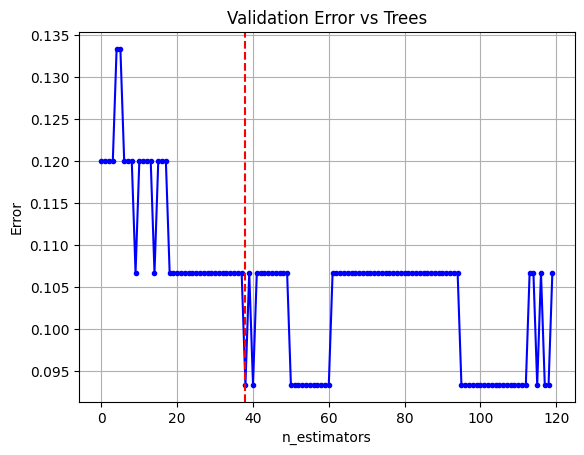

In [13]:
from sklearn.model_selection import train_test_split

X_train_sub, X_val, y_train_sub, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
gbrt_es = GradientBoostingClassifier(n_estimators=120)
gbrt_es.fit(X_train_sub, y_train_sub)

errors = [1 - accuracy_score(y_val, pred) for pred in gbrt_es.staged_predict(X_val)]

best_n_estimators = np.argmin(errors)
gbrt_best = GradientBoostingClassifier(n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

plt.plot(errors, "b.-")
plt.axvline(best_n_estimators, linestyle="--", color="red")
plt.title("Validation Error vs Trees")
plt.xlabel("n_estimators")
plt.ylabel("Error")
plt.grid()
plt.show()
